**AutoML OSS入門（7）**

# ディープラーニングモデルを自動構築するAutoML OSS「AutoKeras」

本ノートブックの紹介記事と併せてご覧ください。
- [＠IT連載 AutoML OSS入門（７）- 第7回「ディープラーニングモデルを自動構築するAutoML OSS「AutoKeras」」](https://atmarkit.itmedia.co.jp/ait/articles/2112/13/news006.html)

また、ノートブックの扱い方については、連載記事の第1回を参照してください。
- [＠IT連載 AutoML OSS入門（１）- 第1回「機械学習モデル構築作業の煩雑さを解消する「AutoML」とは――歴史、動向、利用のメリットを整理する」](https://www.atmarkit.co.jp/ait/articles/2107/02/news006.html)


## MNISTでAutoML
MNISTデータセットを使って、AutoKerasで手書き数字の分類を行ってみます。

学習にかなり時間がかかりますので、Colab上部の「ランタイム」タブから「ランタイムのタイプを変更」をクリックし、「ハードウェアアクセラレータ」を「GPU」に設定してください。

### セットアップ
AutoKerasをインストールします。<br>
ただ、執筆時点のColabでGPU環境を利用しようとすると、ColabのCUDA/cuDNNバージョンではAutoKerasインストール時にインストールされるTensorFlow 2.5.2が正常に動作しないので、TensorFlow 2.4.0をインストールします。

In [17]:
# インストール
!pip install autokeras
!pip install tensorflow==2.4.0

### ライブラリのインポート
各種ライブラリをインポートします。

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import autokeras as ak
print(ak.__version__)

1.0.16.post1


### データのロード
TensorFlowのデータセットからMNISTのデータをロードします。

In [19]:
# データのロード
(X_train, y_train), (X_test, y_test) = mnist.load_data()

ロードしたデータの一部を表示してみます。

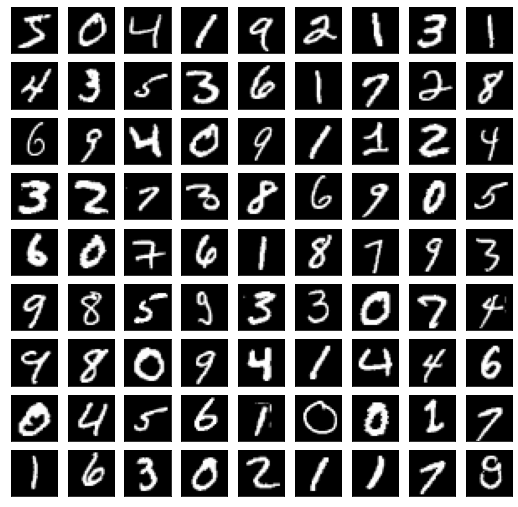

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# MNISTデータの表示
fig = plt.figure(figsize=(9, 9))
for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')

### モデルの学習と評価
学習データでモデルを学習します。


In [21]:
# モデルの学習
clf = ak.ImageClassifier(overwrite=True, max_trials=1, seed=42)
clf.fit(X_train, y_train, epochs=10)

Trial 1 Complete [00h 02m 44s]
val_loss: 0.041069649159908295

Best val_loss So Far: 0.041069649159908295
Total elapsed time: 00h 02m 44s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.3058 - accuracy: 0.9063
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0778 - accuracy: 0.9764
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0636 - accuracy: 0.9806
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0536 - accuracy: 0.9843
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0459 - accuracy: 0.9855
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0421 - accuracy: 0.9865
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0398 - accuracy: 0.9879
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0333 - accuracy: 0.9889


In [22]:
# 学習済みモデルのエクスポート
model = clf.export_model()
# モデル構造の確認
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 28, 28)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 28, 28, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0     

テストデータで評価します。

In [23]:
# モデルの評価
print(clf.evaluate(X_test, y_test))

313/313 [==============================] - 2s 6ms/step - loss: 0.0310 - accuracy: 0.9907
[0.03100581280887127, 0.9907000064849854]


### モデルの保存と利用
AutoKerasの学習済みのモデルを保存し、tf.kerasのload_model()で読み込んで使用します。

In [24]:
# モデルの保存
model.save('autokeras_model', save_format='tf')

INFO:tensorflow:Assets written to: autokeras_model/assets


In [25]:
from tensorflow.keras.models import load_model
# モデルの読み込み
loaded_model = load_model('autokeras_model', custom_objects=ak.CUSTOM_OBJECTS)

テストデータで評価します。

In [26]:
from tensorflow.keras.utils import to_categorical
# テストデータの評価
print(loaded_model.evaluate(X_test, to_categorical(y_test)))

313/313 [==============================] - 2s 5ms/step - loss: 0.0310 - accuracy: 0.9907
[0.03100581280887127, 0.9907000064849854]


正しく予測できたデータと予測を誤ったデータを少し表示してみます。


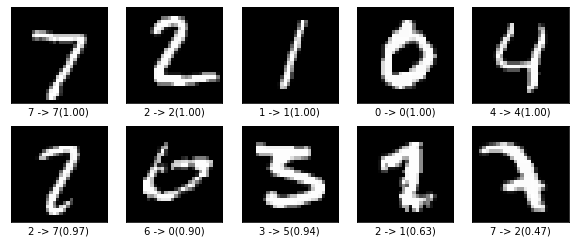

In [27]:
# テストデータの予測
preds = loaded_model.predict(X_test)

# 一部予測結果(正解・不正解)の表示
res = np.argmax(preds, axis=1)
ok = []
ng = []
for i in range(len(res)):
    if res[i] == y_test[i]:
        ok.append(i)
    else:
        ng.append(i)

fig = plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if i < 5:
        idx = ok[i]
        plt.imshow(X_test[idx], cmap='gray')
        label = f'{y_test[idx]} -> {res[idx]}({preds[idx][res[idx]]:.2f})'
        plt.xlabel(label)
    else:
        idx = ng[i - 5]
        plt.imshow(X_test[idx], cmap='gray')
        label = f'{y_test[idx]} -> {res[idx]}({preds[idx][res[idx]]:.2f})'
        plt.xlabel(label)
plt.show()

以上で、MNISTデータを使ったAutoKerasの紹介は終わりです。